# Open-Ended Grounding in OCID dataset

In [2]:
cd ..

/home/p300488/LMM_utils/LMM-grasp-anything/OWG


/home/p300488/miniconda3/envs/LLM/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
import json 
import clip
import torch
from tqdm import tqdm

# helper function
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [4]:
from getpass import getpass

openai_api_key = getpass()

 ········


In [5]:
# either set your openai key environment variable
#openai_api_key = os.environ['OPENAI_API_KEY']

# or read from getpass
os.environ['OPENAI_API_KEY'] = openai_api_key

In [6]:
from owg.visual_prompt import VisualPrompterGrounding

### Example inference with OWG

Load example image from OCID

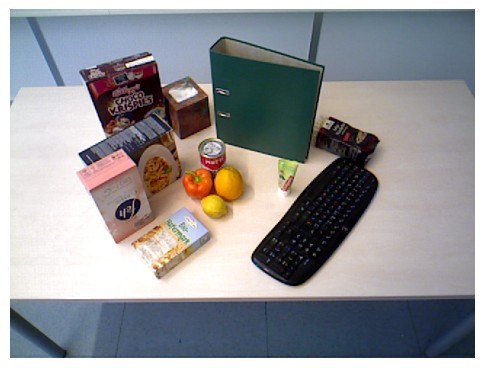

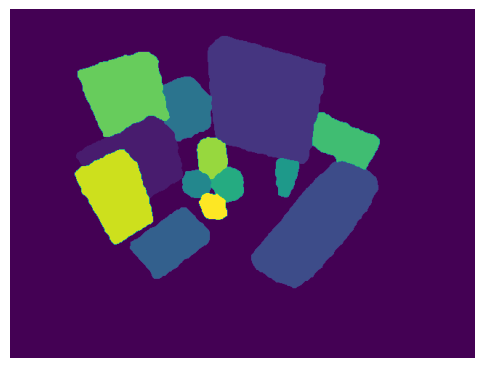

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [7]:
img_path = './media/example_rgb_2018-08-21-11-40-54.png'
mask_path = './media/example_mask_2018-08-21-11-40-54.png'

image_pil = Image.open(img_path)
image_np = np.array(image_pil)
ins_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
obj_ids = np.unique(ins_mask)[1:]

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display_image(image_pil, (6,6))
display_image(ins_mask, (6,6))
print(obj_ids)

In [8]:
grounder = VisualPrompterGrounding('config/ocid/OWG.yaml', debug=True)

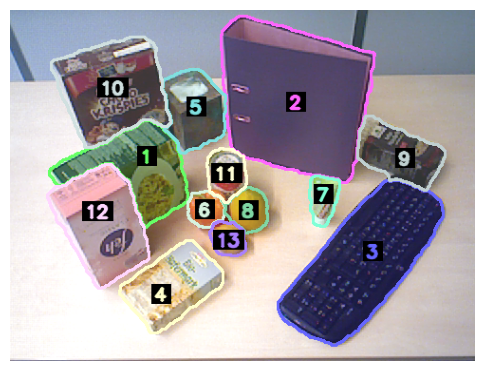

In [8]:
# display mark-based prompt
all_masks = np.stack([ins_mask == objID for objID in obj_ids])
visual_prompt, out_data = grounder.prepare_image_prompt(
    image_pil, {'masks':all_masks})
marked_image_grounding = visual_prompt[1]
image_grounding = out_data['raw_image']
markers = out_data['markers']

display_image(marked_image_grounding, (6,6))

In [9]:
# example referring queries
queries = [
    "binder",
    "lemon",
    "bell pepper",
    "Choco krispies",
    "cube",
    "pink tissues package",
    "black food package",
    "tomato soup can",
    "leftmost fruit",
    "pasta box standing on its side, left from bell pepper",
    "I want to wash my teeth",
    "I want to send an email"
]

binder
GPT response:
The binder in the image is the large green object standing upright. In the marked image, it is labeled with ID 2.

My final answer is: [2]



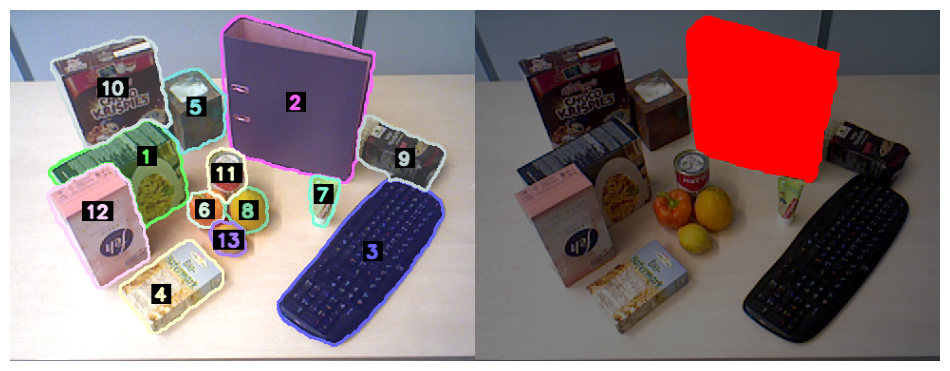

------------------------------------------------------------------------------------------------------------------------------
lemon
GPT response:
The lemon is the yellow fruit located near the center of the image. In the marked image, it corresponds to ID 8.

My final answer is: [8]



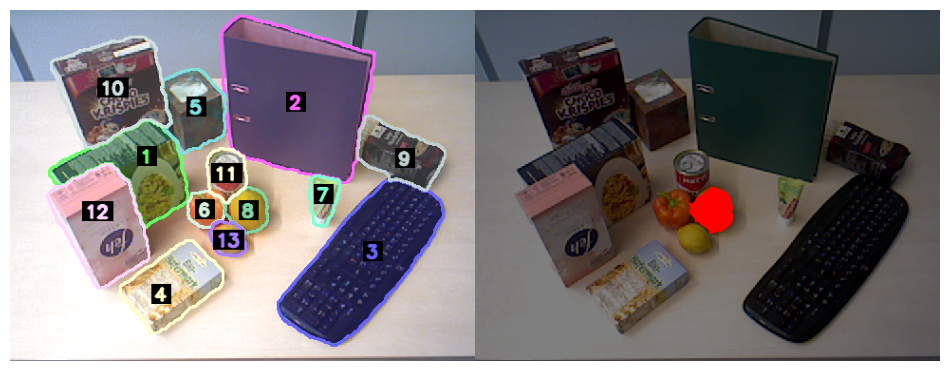

------------------------------------------------------------------------------------------------------------------------------
bell pepper
GPT response:
The bell pepper in the image is the orange object located near the center, next to the lemon. In the marked image, it corresponds to ID 6.

My final answer is: [6]



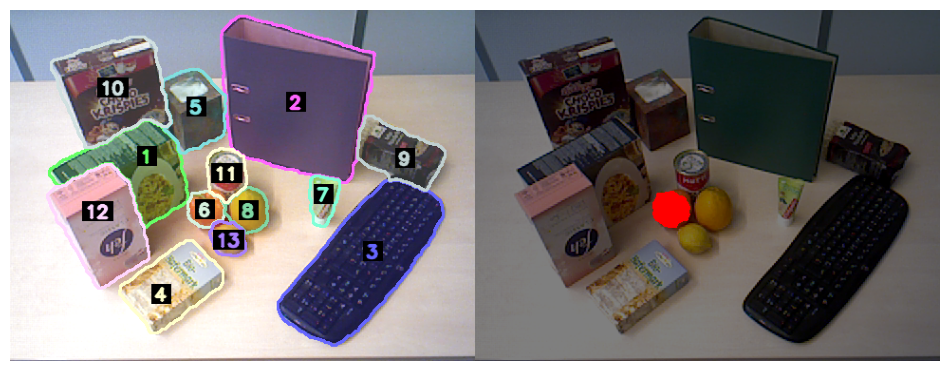

------------------------------------------------------------------------------------------------------------------------------
Choco krispies
GPT response:
The "Choco Krispies" box is located in the top left corner of the image. In the marked image, it corresponds to ID 10.

My final answer is: [10]



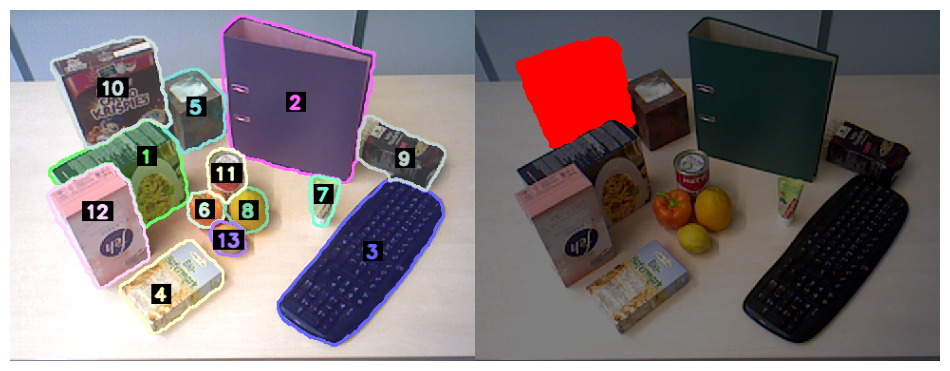

------------------------------------------------------------------------------------------------------------------------------
cube
GPT response:
To identify the cube, we need to look for an object with a cube-like shape. In the image, the object that resembles a cube is the one with a square base and equal height, which is the brown box near the top center of the image.

In the marked image, this object is labeled with ID 5.

My final answer is: [5]



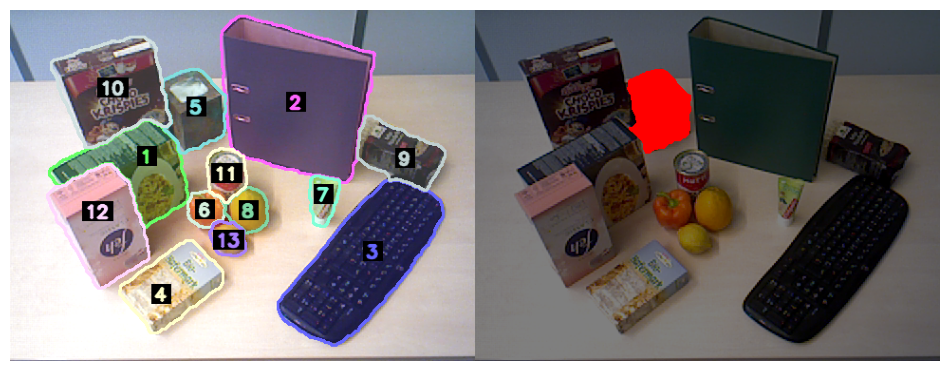

------------------------------------------------------------------------------------------------------------------------------
pink tissues package
GPT response:
The pink tissues package is located in the bottom left area of the image. It is marked with ID 12.

My final answer is: [12]



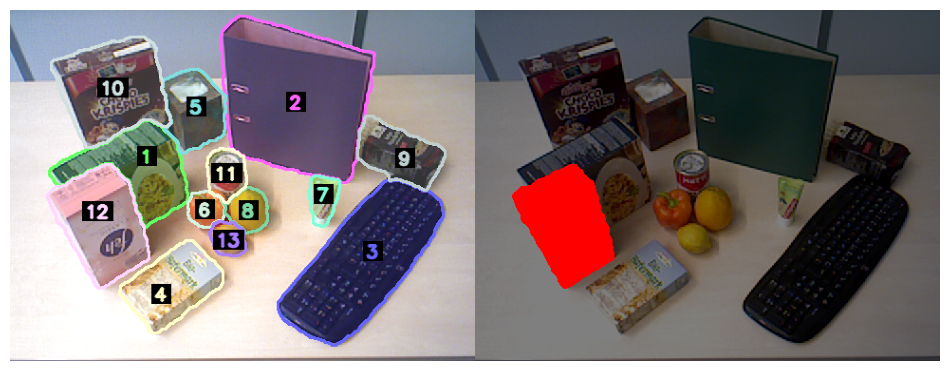

------------------------------------------------------------------------------------------------------------------------------
black food package
GPT response:
To find the black food package, I will look for a package that is black in color in the raw image.

1. The object labeled with ID 9 in the marked image is a black package.

My final answer is: [9]



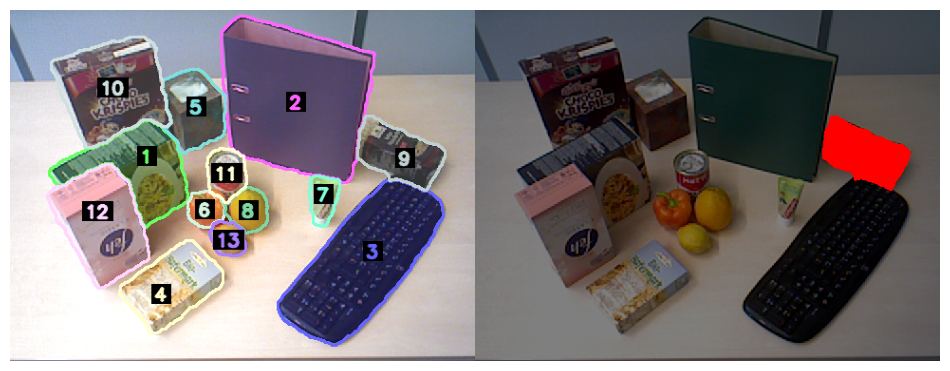

------------------------------------------------------------------------------------------------------------------------------
tomato soup can
GPT response:
To find the tomato soup can, I will look for a can with a label that typically indicates tomato soup. In the raw image, there is a can with a red and white label, which is commonly associated with tomato soup.

Now, I will identify the corresponding ID in the marked image. The can is located near the center of the image, next to the orange and lemon.

The ID for the tomato soup can is 11.

My final answer is: [11]



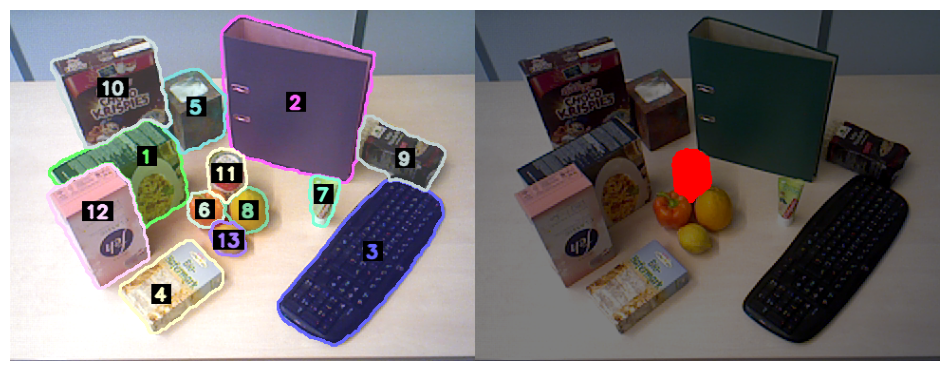

------------------------------------------------------------------------------------------------------------------------------
leftmost fruit
GPT response:
To find the leftmost fruit, we need to identify the fruits in the image and determine which one is positioned furthest to the left.

In the image, the fruits are:
- An orange fruit (ID 6)
- A yellow fruit (ID 8)
- Another yellow fruit (ID 13)

The leftmost fruit is the orange fruit with ID 6.

My final answer is: [6]



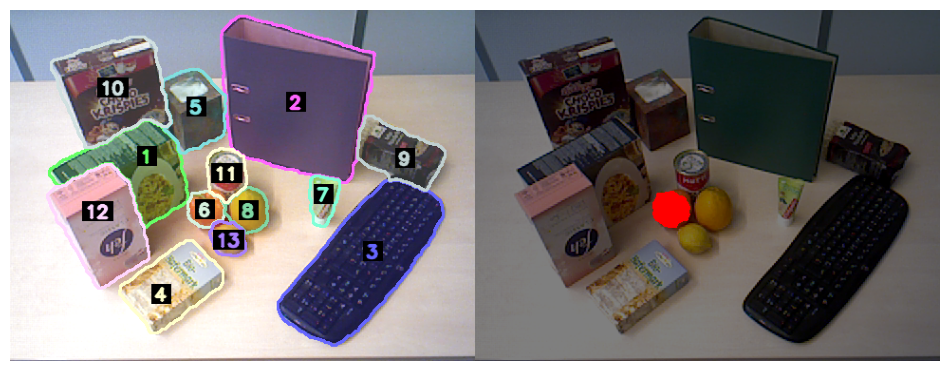

------------------------------------------------------------------------------------------------------------------------------
pasta box standing on its side, left from bell pepper
GPT response:
To find the pasta box standing on its side, left from the bell pepper, follow these steps:

1. Identify the bell pepper in the image. In the marked image, the bell pepper is labeled as ID 6.
2. Look to the left of the bell pepper for a pasta box standing on its side. In the marked image, the pasta box is labeled as ID 1.

My final answer is: [1]



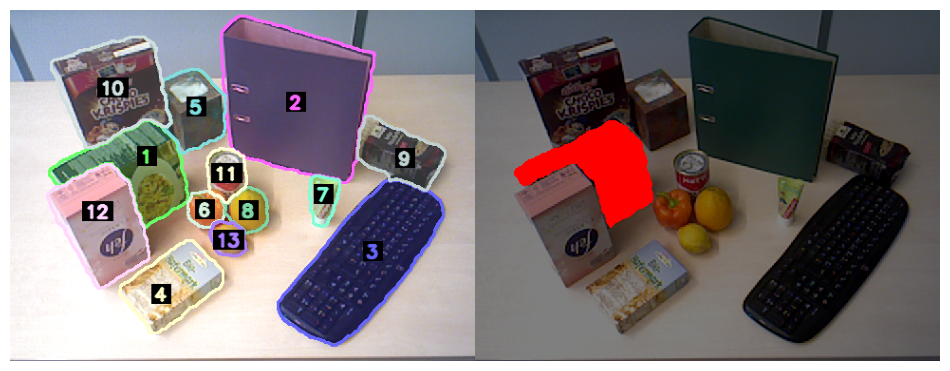

------------------------------------------------------------------------------------------------------------------------------
I want to wash my teeth
GPT response:
To wash your teeth, you would need toothpaste. In the image, the toothpaste is the small tube located near the center-right. 

Looking at the marked image, the toothpaste corresponds to ID 7.

My final answer is: [7]



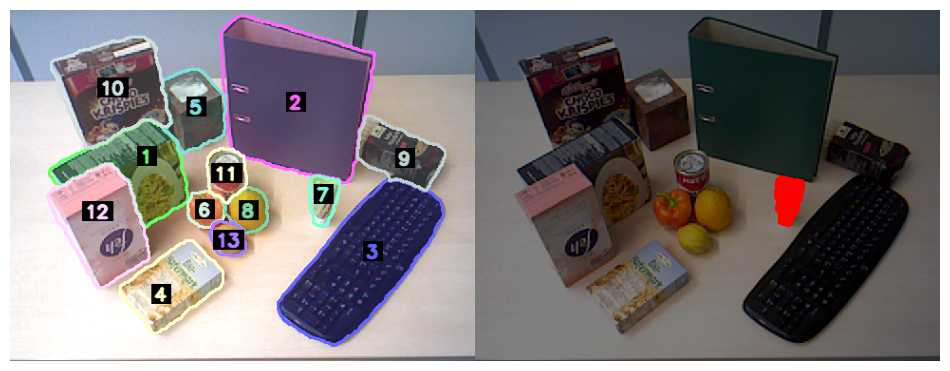

------------------------------------------------------------------------------------------------------------------------------
I want to send an email
GPT response:
To send an email, you would need a keyboard. 

In the images provided, the keyboard is labeled with ID 3.

My final answer is: [3]



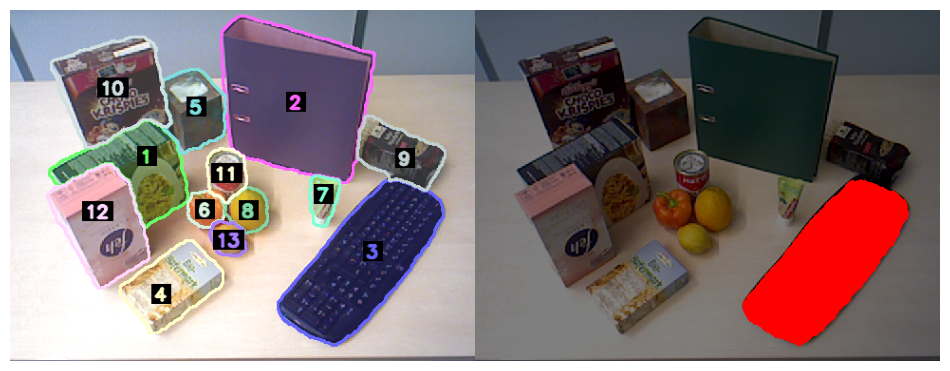

------------------------------------------------------------------------------------------------------------------------------


In [10]:
for user_input in queries:
    print(user_input)
    _, output_mask, _ = grounder.request(
        text_query=user_input, image=image_pil, data={'masks':all_masks}
    )
    canvas = (0.5 * np.array(image_grounding).copy()).astype(np.uint8)
    canvas[output_mask==True,:] = np.array([255,0,0])
    display_image(np.hstack([marked_image_grounding, canvas]), (12,6))
    print('---' * 42)

Load dataset and metrics

In [11]:
test_dataset = torch.load("/home/p300488/LMM_utils/LMM-grasp-anything/_dumps/ocid_test_grounding_v4_all.p")

In [12]:
# referring segmentation
def segmentation_metrics(preds, masks, device):
    iou_list = []
    for pred, mask in zip(preds, masks):
        # pred: (H, W): bool, mask: (H, W): bool
        # iou
        inter = np.logical_and(pred, mask)
        union = np.logical_or(pred, mask)
        iou = np.sum(inter) / (np.sum(union) + 1e-6)
        iou_list.append(iou)
    iou_list = np.stack(iou_list)
    iou_list = torch.from_numpy(iou_list).to(device)
    prec_list = []
    for thres in torch.arange(0.5, 1.0, 0.1):
        tmp = (iou_list > thres).float().mean()
        prec_list.append(tmp)
    iou = iou_list.mean()
    iou_std = iou_list.var()
    prec = {}
    temp = '  '
    for i, thres in enumerate(range(5, 10)):
        key = 'Pr@{}'.format(thres * 10)
        value = prec_list[i].item()
        prec[key] = value
        temp += "{}: {:.2f}  ".format(key, 100. * value)
    head = 'Evaluation: IoU (mean)={:.2f}, (std)={:.2f}'.format(100. * iou.item(), 100. * iou_std.item())
    return head + temp, {'iou': iou.item(), 'iou_std': iou_std.item(), **prec}

## Evaluation CLIP

CLIP utils

In [13]:
def article(name):
  return 'an' if name[0] in 'aeiou' else 'a'

def processed_name(name, rm_dot=False):
  # _ for lvis
  # / for obj365
  res = name.replace('_', ' ').replace('/', ' or ').lower()
  if rm_dot:
    res = res.rstrip('.')
  return res

single_template_imagenet = [
    'a photo of {article} {}.'
]

multiple_templates_imagenet = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',


    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [15]:
def build_text_embedding(categories, prompt_engineering=True, this_is=True, single_template=single_template_imagenet, multiple_templates=multiple_templates_imagenet):
  if prompt_engineering:
    templates = multiple_templates
  else:
    templates = single_template

  with torch.no_grad():
    all_text_embeddings = []
    #print('Building text embeddings...')
    for category in categories:
      texts = [
        template.format(processed_name(category['name'], rm_dot=True),
                        article=article(category['name']))
        for template in templates]
      if this_is:
        texts = [
                 'This is ' + text if text.startswith('a') or text.startswith('the') else text 
                 for text in texts
                 ]
      texts = clip.tokenize(texts).to(device) #tokenize
      text_embeddings = model.encode_text(texts) #embed with text encoder
      text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
      text_embedding = text_embeddings.mean(dim=0) #average accross prompt templates
      text_embedding /= text_embedding.norm()
      all_text_embeddings.append(text_embedding)
    all_text_embeddings = torch.stack(all_text_embeddings, dim=1)
    
  return all_text_embeddings.to(device).T

In [16]:
def extract_features_pt(images):
    image_inputs = torch.stack([preprocess(Image.fromarray(i)).to(device) for i in images])
    image_features = model.encode_image(image_inputs)
    image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
    return image_features_norm

In [17]:
def clip_get_most_similar_queries(object_image_features, text_embedding, masks, image, show=False):
    similarities = object_image_features @ text_embedding.T
    most_similar_indices =  similarities.mean(1).argmax(0)
    # most_similar_indices =  similarities.squeeze().argmax(0).cpu().numpy()
    
    if show:
        for prompt, index in zip(category_names, most_similar_indices):
            print(prompt)
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_anns([masks[index]])
            plt.axis('off')
            plt.show() 
    
    #return [mask for i, mask in enumerate(masks) if i in most_similar_indices]
    return  masks[most_similar_indices.item()], most_similar_indices.item()

In [18]:
def clip_get_most_similar_imgs(object_image_features, category_name_string, masks, image, show=True):
    # Preprocessing categories and get params
    category_names = [x.strip() for x in category_name_string.split(';')]
    categories = [{'name': item, 'id': idx+1,} for idx, item in enumerate(category_names)]
    
    text_embedding = build_text_embedding(categories)
    
    similarities = object_image_features @ text_embedding.T
    most_similar_indices =  similarities.mean(0).argmax(0)
    # most_similar_indices =  similarities.squeeze().argmax(0).cpu().numpy()
    
    if show:
        for prompt, index in zip(category_names, most_similar_indices):
            print(prompt)
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_anns([masks[index]])
            plt.axis('off')
            plt.show() 
    
    #return [mask for i, mask in enumerate(masks) if i in most_similar_indices]
    return most_similar_indices

In [19]:
# get contour out of binary mask
def get_mask_contour(binary_mask):
    # Find all contours in the binary mask
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8) * 255, 
            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Combine all contours into one array
    #all_contours = np.vstack(contours[i] for i in range(len(contours)))
    all_contours = np.vstack(contours)
    
    return all_contours


# get bbox out of binary mask
def get_mask_bbox(binary_mask):
    cont = get_mask_contour(binary_mask)
    x, y, w, h = cv2.boundingRect(cont)
    return [x,y,w,h]


# fit ellipse in contour out of binary mask
def get_mask_ellipse(binary_mask):
    cont = get_mask_contour(binary_mask)
    try:
        ellipse = cv2.fitEllipse(cont)
    except:
        x,y,w,h = cv2.boundingRect(cont)
        ellipse = ((x,y), (w,h), 0)
    return ellipse

In [20]:
# construct seg masks from dataset
seg_masks = {}
for refer_type, data in test_dataset.items():
    seg_masks[refer_type] = {}
    for samp in data:
        seg_masks[refer_type][samp['scene_id']] = samp['masks_gt']

In [21]:
# eval function
@torch.no_grad()
def eval_dataset(predict_fn):
    metrics = {}
    for refer_type, data in test_dataset.items():
        print(refer_type)
        all_preds, all_gt = [], []
        for samp in tqdm(data):

            img = samp['img']
            masks = seg_masks[refer_type][samp['scene_id']]
            boxes = [get_mask_bbox(m) for m in masks]

            pred = predict_fn(img, samp['sentence'], masks, boxes)
            
            all_preds.append(pred)
            all_gt.append(samp['mask'])

        met = segmentation_metrics(all_preds, all_gt, device)
        print(met[0])
        print()
        metrics[refer_type] = met[1]
        torch.cuda.empty_cache()
    return metrics

### ReCLIP (No relation resolution)

In [22]:
def extract_features_reclip(image, masks, boxes):
    object_image_features = []
    for m, bb in zip(masks, boxes):
        # ReCLIP style - both mask and crop
        #segm = m['segmentation']
        segm = m.copy()
        mask = np.ones_like(image) * 0xff
        mask[segm==True] = image[segm==True]
        # print(mask.shape)
        mask_input = preprocess(Image.fromarray(mask)).to(device)

        #bbox = m['bbox']
        #x, y, w, h = int(np.floor(bbox[0])), int(np.floor(bbox[1])), int(np.ceil(bbox[2])), int(np.ceil(bbox[3]))
        x, y, w, h = bb
        crop_box = image[y:y+h, x:x+w, :]
        box_input = preprocess(Image.fromarray(crop_box)).to(device)

        image_inputs = torch.stack([mask_input, box_input])
        image_features = model.encode_image(image_inputs)
        image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
        object_image_features.append(image_features_norm)

    object_image_features = torch.stack(object_image_features)
    
    return object_image_features

In [23]:
def predict_reclip(image, query, masks, boxes):
    # Preprocessing categories and get params
    category_names = [x.strip() for x in query.split(';')]
    categories = [{'name': item, 'id': idx+1,} for idx, item in enumerate(category_names)]
    
    text_embedding = build_text_embedding(categories, prompt_engineering=False, this_is=True,
                                         )
    #prompt = query + ';'
    object_feats = extract_features_reclip(image, masks, boxes)
    mask_out, _ = clip_get_most_similar_queries(object_feats, text_embedding, masks, image)
    return mask_out

In [24]:
results_reclip = eval_dataset(predict_reclip)

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.56it/s]


Evaluation: IoU (mean)=46.15, (std)=26.92  Pr@50: 46.15  Pr@60: 46.15  Pr@70: 46.15  Pr@80: 46.15  Pr@90: 46.15  

visual_relations


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  6.52it/s]


Evaluation: IoU (mean)=47.37, (std)=26.32  Pr@50: 47.37  Pr@60: 47.37  Pr@70: 47.37  Pr@80: 47.37  Pr@90: 47.37  

multi_hop


100%|███████████████████████████████████████████| 24/24 [00:03<00:00,  6.49it/s]


Evaluation: IoU (mean)=20.83, (std)=17.21  Pr@50: 20.83  Pr@60: 20.83  Pr@70: 20.83  Pr@80: 20.83  Pr@90: 20.83  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [00:04<00:00,  7.22it/s]


Evaluation: IoU (mean)=27.27, (std)=20.45  Pr@50: 27.27  Pr@60: 27.27  Pr@70: 27.27  Pr@80: 27.27  Pr@90: 27.27  

affordance


100%|███████████████████████████████████████████| 16/16 [00:01<00:00,  8.92it/s]


Evaluation: IoU (mean)=62.50, (std)=25.00  Pr@50: 62.50  Pr@60: 62.50  Pr@70: 62.50  Pr@80: 62.50  Pr@90: 62.50  

name


100%|███████████████████████████████████████████| 42/42 [00:04<00:00,  8.74it/s]


Evaluation: IoU (mean)=73.81, (std)=19.80  Pr@50: 73.81  Pr@60: 73.81  Pr@70: 73.81  Pr@80: 73.81  Pr@90: 73.81  

attribute


100%|███████████████████████████████████████████| 26/26 [00:03<00:00,  7.01it/s]

Evaluation: IoU (mean)=57.69, (std)=25.38  Pr@50: 57.69  Pr@60: 57.69  Pr@70: 57.69  Pr@80: 57.69  Pr@90: 57.69  



### RedCircle

In [25]:
# visual prmopt
def red_circle_paint(image, masks, boxes, geometry="ellipse"):
    H, W = image.shape[:2]
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    gray3 = cv2.merge([gray, gray, gray])
    blur = cv2.GaussianBlur(image.copy(), (31,31), 0)
    
    prompts=[]
    for m, bb in zip(masks, boxes):
        x, y, w, h = bb
           
        if geometry == 'rectangle':
            draw = cv2.rectangle(image.copy(), (x,y), (x+w,y+h), (255,0,0), thickness=3)
            prompt_mask = cv2.rectangle(np.zeros((H, W), dtype=np.uint8),
                                      (x,y),
                                      (x+w, y+h),
                                      0xff,
                                      -1
            ).astype(bool)

            
        
        elif geometry == 'circle':
            center = int(x + w//2), int(y+h//2)
            rad = max(w,h) // 2
            draw = cv2.circle(image.copy(), center, rad, (255, 0, 0), thickness=3)
            prompt_mask = cv2.circle(np.zeros((H, W), dtype=np.uint8),
                                      center,
                                      rad,
                                      0xff,
                                      -1
            ).astype(bool)
            
            
            
        elif geometry == 'ellipse':
            ell = get_mask_ellipse(m)
            try:
                draw = cv2.ellipse(image.copy(), ell, (255, 0, 0), thickness=3)
                prompt_mask = cv2.ellipse(np.zeros((H, W), dtype=np.uint8),
                                      ell,
                                      0xff,
                                      -1
                ).astype(bool)
            except:
                draw = image.copy()
                prompt_mask = cv2.rectangle(np.zeros((H, W), dtype=np.uint8),
                                      (x,y),
                                      (x+w, y+h),
                                      0xff,
                                      -1
            ).astype(bool)
            

        gray_rev = gray3.copy()
        gray_rev[prompt_mask==True] = image[prompt_mask==True]
        blur_rev = blur.copy()
        blur_rev[prompt_mask==True] = image[prompt_mask==True]
            
        prompt = {'image': draw}
        prompt['gray_reverse'] = gray_rev
        prompt['blur_reverse'] = blur_rev
            
        prompts.append(prompt)
        
    return prompts

In [26]:
def extract_features_redcircle(image, masks, boxes, prompt_type, with_crop=False, with_mask=False):
    visual_prompts = red_circle_paint(image, masks, boxes, geometry=prompt_type)
    
    object_image_features = []

    for im, m, bb in zip(visual_prompts, masks, boxes):
        simple_input = preprocess(Image.fromarray(im['image'])).to(device)
        
        # + grayscale reverse
        gray_rev_input = preprocess(Image.fromarray(im['gray_reverse'])).to(device)

        # + blur reverse
        blur_rev_input = preprocess(Image.fromarray(im['blur_reverse'])).to(device)
        
        image_inputs = torch.stack([simple_input, gray_rev_input, blur_rev_input])
        #image_inputs = torch.stack([simple_input, blur_rev_input])
        
        if with_mask:
            segm = m.copy()
            mask = np.ones_like(image) * 0xff
            mask[segm==True] = image[segm==True]
            mask_input = preprocess(Image.fromarray(mask)).to(device)

            image_inputs = torch.cat([image_inputs, mask_input.unsqueeze(0)])
            
        if with_crop:
            x, y, w, h = bb
            crop_box = image[y:y+h, x:x+w, :]
            box_input = preprocess(Image.fromarray(crop_box)).to(device)
            
            image_inputs = torch.cat([image_inputs, box_input.unsqueeze(0)], dim=0)

        
        image_features = model.encode_image(image_inputs)
        image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
        object_image_features.append(image_features_norm)
        
    return torch.stack(object_image_features)

In [27]:
def predict_redcircle( prompt_engineering=False,
                        prompt_type = 'ellipse',
                        this_is=False,
                        with_crop=False,
                        with_mask=False
                     ):
    
    def _predict_redcircle(image, query, masks, boxes):
        # Preprocessing categories and get params
        category_names = [x.strip() for x in query.split(';')]
        categories = [{'name': item, 'id': idx+1,} for idx, item in enumerate(category_names)]

        text_embedding = build_text_embedding(categories, prompt_engineering=prompt_engineering, this_is=this_is,
                                             )
        #prompt = query + ';'
        object_feats = extract_features_redcircle(image, masks, boxes, prompt_type, with_crop, with_mask)
        mask_out, _ = clip_get_most_similar_queries(object_feats, text_embedding, masks, image)
        return mask_out
    
    return _predict_redcircle

In [28]:
# RedCircle: ellipse + blur + gray + multi
results_redcircle = eval_dataset(predict_redcircle(prompt_engineering=True, prompt_type='ellipse'))

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.81it/s]


Evaluation: IoU (mean)=46.15, (std)=26.92  Pr@50: 46.15  Pr@60: 46.15  Pr@70: 46.15  Pr@80: 46.15  Pr@90: 46.15  

visual_relations


100%|███████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Evaluation: IoU (mean)=36.84, (std)=24.56  Pr@50: 36.84  Pr@60: 36.84  Pr@70: 36.84  Pr@80: 36.84  Pr@90: 36.84  

multi_hop


100%|███████████████████████████████████████████| 24/24 [00:06<00:00,  3.67it/s]


Evaluation: IoU (mean)=20.83, (std)=17.21  Pr@50: 20.83  Pr@60: 20.83  Pr@70: 20.83  Pr@80: 20.83  Pr@90: 20.83  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [00:08<00:00,  4.11it/s]


Evaluation: IoU (mean)=24.24, (std)=18.94  Pr@50: 24.24  Pr@60: 24.24  Pr@70: 24.24  Pr@80: 24.24  Pr@90: 24.24  

affordance


100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  4.81it/s]


Evaluation: IoU (mean)=31.25, (std)=22.92  Pr@50: 31.25  Pr@60: 31.25  Pr@70: 31.25  Pr@80: 31.25  Pr@90: 31.25  

name


100%|███████████████████████████████████████████| 42/42 [00:08<00:00,  4.69it/s]


Evaluation: IoU (mean)=33.33, (std)=22.76  Pr@50: 33.33  Pr@60: 33.33  Pr@70: 33.33  Pr@80: 33.33  Pr@90: 33.33  

attribute


100%|███████████████████████████████████████████| 26/26 [00:06<00:00,  3.93it/s]

Evaluation: IoU (mean)=46.15, (std)=25.85  Pr@50: 46.15  Pr@60: 46.15  Pr@70: 46.15  Pr@80: 46.15  Pr@90: 46.15  



### FGVP

In [29]:
# visual prmopt
def fgvp_paint(image, masks,boxes):
    H, W = image.shape[:2]
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    gray3 = cv2.merge([gray, gray, gray])
    blur = cv2.GaussianBlur(image.copy(), (31,31), 0)
    
    prompts=[]
    for m, bb in zip(masks, boxes):
        x, y, w, h = bb
        
        segm = m.copy()
        cont = get_mask_contour(segm)
        
        draw = cv2.drawContours(image.copy(), [cont], 0, (255, 0, 0), thickness=3)    
        #draw = cv2.rectangle(image.copy(), (x,y), (x+w,y+h), (255,0,0), thickness=3)
        
        gray_rev = gray3.copy()
        gray_rev[segm==True] = image[segm==True]
        blur_rev = blur.copy()
        blur_rev[segm==True] = image[segm==True]
            
        prompt = {'image': draw}
        prompt['gray_reverse'] = gray_rev
        prompt['blur_reverse'] = blur_rev
            
        prompts.append(prompt)
        
    return prompts

In [30]:
def extract_features_fgvp(image, masks, boxes, with_crop=False, with_mask=False):
    visual_prompts = fgvp_paint(image, masks, boxes)
    
    object_image_features = []

    for im, m, bb in zip(visual_prompts, masks, boxes):
        simple_input = preprocess(Image.fromarray(im['image'])).to(device)
        
        # + grayscale reverse
        gray_rev_input = preprocess(Image.fromarray(im['gray_reverse'])).to(device)

        # + blur reverse
        blur_rev_input = preprocess(Image.fromarray(im['blur_reverse'])).to(device)
        
        image_inputs = torch.stack([simple_input, gray_rev_input, blur_rev_input])
        #image_inputs = torch.stack([simple_input, gray_rev_input])
        
        if with_mask:
            segm = m.copy()
            mask = np.ones_like(image) * 0xff
            mask[segm==True] = image[segm==True]
            mask_input = preprocess(Image.fromarray(mask)).to(device)

            image_inputs = torch.cat([image_inputs, mask_input.unsqueeze(0)])
            
        if with_crop:
            x, y, w, h = bb
            crop_box = image[y:y+h, x:x+w, :]
            box_input = preprocess(Image.fromarray(crop_box)).to(device)
            
            image_inputs = torch.cat([image_inputs, box_input.unsqueeze(0)], dim=0)

        
        image_features = model.encode_image(image_inputs)
        image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
        object_image_features.append(image_features_norm)
        
    return torch.stack(object_image_features)

In [31]:
def predict_fgvp( prompt_engineering=False,
                        this_is=False,
                        with_crop=False,
                        with_mask=False
                     ):
    
    def _predict_fgvp(image, query, masks, boxes):
        # Preprocessing categories and get params
        category_names = [x.strip() for x in query.split(';')]
        categories = [{'name': item, 'id': idx+1,} for idx, item in enumerate(category_names)]

        text_embedding = build_text_embedding(categories, prompt_engineering=prompt_engineering, this_is=this_is,
                                             )
        #prompt = query + ';'
        object_feats = extract_features_fgvp(image, masks, boxes, with_crop, with_mask)
        mask_out, _ = clip_get_most_similar_queries(object_feats, text_embedding, masks, image)
        return mask_out
    
    return _predict_fgvp

In [32]:
results_fgvp = eval_dataset(predict_fgvp(prompt_engineering=False, with_crop=False, with_mask=False))

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:01<00:00,  6.64it/s]


Evaluation: IoU (mean)=53.85, (std)=26.92  Pr@50: 53.85  Pr@60: 53.85  Pr@70: 53.85  Pr@80: 53.85  Pr@90: 53.85  

visual_relations


100%|███████████████████████████████████████████| 19/19 [00:04<00:00,  4.10it/s]


Evaluation: IoU (mean)=36.84, (std)=24.56  Pr@50: 36.84  Pr@60: 36.84  Pr@70: 36.84  Pr@80: 36.84  Pr@90: 36.84  

multi_hop


100%|███████████████████████████████████████████| 24/24 [00:05<00:00,  4.12it/s]


Evaluation: IoU (mean)=25.00, (std)=19.57  Pr@50: 25.00  Pr@60: 25.00  Pr@70: 25.00  Pr@80: 25.00  Pr@90: 25.00  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [00:07<00:00,  4.66it/s]


Evaluation: IoU (mean)=33.33, (std)=22.92  Pr@50: 33.33  Pr@60: 33.33  Pr@70: 33.33  Pr@80: 33.33  Pr@90: 33.33  

affordance


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.55it/s]


Evaluation: IoU (mean)=37.50, (std)=25.00  Pr@50: 37.50  Pr@60: 37.50  Pr@70: 37.50  Pr@80: 37.50  Pr@90: 37.50  

name


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.44it/s]


Evaluation: IoU (mean)=50.00, (std)=25.61  Pr@50: 50.00  Pr@60: 50.00  Pr@70: 50.00  Pr@80: 50.00  Pr@90: 50.00  

attribute


100%|███████████████████████████████████████████| 26/26 [00:05<00:00,  4.44it/s]

Evaluation: IoU (mean)=53.85, (std)=25.85  Pr@50: 53.85  Pr@60: 53.85  Pr@70: 53.85  Pr@80: 53.85  Pr@90: 53.85  



In [33]:
results_fgvp_star = eval_dataset(predict_fgvp(prompt_engineering=True, with_crop=False, with_mask=True))

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Evaluation: IoU (mean)=69.23, (std)=23.08  Pr@50: 69.23  Pr@60: 69.23  Pr@70: 69.23  Pr@80: 69.23  Pr@90: 69.23  

visual_relations


100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  3.04it/s]


Evaluation: IoU (mean)=42.11, (std)=25.73  Pr@50: 42.11  Pr@60: 42.11  Pr@70: 42.11  Pr@80: 42.11  Pr@90: 42.11  

multi_hop


100%|███████████████████████████████████████████| 24/24 [00:08<00:00,  3.00it/s]


Evaluation: IoU (mean)=29.17, (std)=21.56  Pr@50: 29.17  Pr@60: 29.17  Pr@70: 29.17  Pr@80: 29.17  Pr@90: 29.17  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [00:10<00:00,  3.27it/s]


Evaluation: IoU (mean)=33.33, (std)=22.92  Pr@50: 33.33  Pr@60: 33.33  Pr@70: 33.33  Pr@80: 33.33  Pr@90: 33.33  

affordance


100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.92it/s]


Evaluation: IoU (mean)=56.25, (std)=26.25  Pr@50: 56.25  Pr@60: 56.25  Pr@70: 56.25  Pr@80: 56.25  Pr@90: 56.25  

name


100%|███████████████████████████████████████████| 42/42 [00:11<00:00,  3.78it/s]


Evaluation: IoU (mean)=66.67, (std)=22.76  Pr@50: 66.67  Pr@60: 66.67  Pr@70: 66.67  Pr@80: 66.67  Pr@90: 66.67  

attribute


100%|███████████████████████████████████████████| 26/26 [00:08<00:00,  3.07it/s]

Evaluation: IoU (mean)=65.38, (std)=23.54  Pr@50: 65.38  Pr@60: 65.38  Pr@70: 65.38  Pr@80: 65.38  Pr@90: 65.38  



## Evaluation OWG

In [34]:
grounder = VisualPrompterGrounding('config/ocid/OWG.yaml', debug=False)

In [13]:
def eval_dataset_owg(dataset, show=False, cache=None):
    metrics = {}
    for refer_type, data in dataset.items():
        print(refer_type)
        all_preds, all_gt =[], []
        for samp in tqdm(data):
            img = samp['img']
            mask_gt = samp['mask']
            query = samp['sentence']
            all_masks = samp['masks_gt']
        
            crop_params = grounder.image_crop
            mask_show = img.copy()
            mask_show[mask_gt==True, :] = np.array([255,0,0])
            mask_show = (
                mask_show[crop_params[0]:crop_params[2], crop_params[1]:crop_params[3]].copy())
            mask_gt_cropped = (
                mask_gt[crop_params[0]:crop_params[2], crop_params[1]:crop_params[3]].copy())

            if show:
                visual_prompt, out_data = grounder.prepare_image_prompt(
                    image=img.copy(), data={'masks':all_masks}
                )
                markers = out_data['markers']
                image_grounding = out_data['raw_image']
                marked_image_grounding = visual_prompt[-1]
                
            if cache is None:
                try:
                    response, output_mask, _ = grounder.request(
                        text_query=query, image=img, data={'masks':all_masks}
                    )
                except:
                    print('format error')
                    output_mask = np.zeros_like(mask_gt_cropped)
            else:
                scene_id = samp['scene_id']
                visual_prompt, out_data = grounder.prepare_image_prompt(
                    image=img.copy(), data={'masks':all_masks}
                )
                markers = out_data['markers']
                image_grounding = out_data['raw_image']
                
                response =  cache[refer_type][scene_id]['r']
                try:
                    _, output_mask, _ = grounder.parse_response(
                        response[0], data={'markers':markers}
                    )
                except:
                    # response format error, give empty mask prediction
                    print('format error')
                    output_mask = np.zeros_like(mask_gt_cropped)
            if show:
                canvas = (0.5 * np.array(image_grounding).copy()).astype(np.uint8)
                canvas[output_mask==True,:] = np.array([255,0,0])
                print(query)
                display_image(
                    np.hstack([mask_show, canvas]), (8,4))
        
            all_preds.append(output_mask)
            all_gt.append(mask_gt_cropped)
    
        met = segmentation_metrics(all_preds, all_gt, device='cuda')
        print(met[0])
        print()
        metrics[refer_type] = met[1]
        torch.cuda.empty_cache()
    
    return metrics
    

Results with now deprecated `gpt-4-vision-preview` (cached responses)

In [36]:
gpt4_turbo_responses = json.load(open('/home/p300488/LMM_utils/LMM-grasp-anything/_dumps/responses_v4_final.json'))
results_owg = eval_dataset_owg(test_dataset, cache=gpt4_turbo_responses)

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 43.58it/s]


Evaluation: IoU (mean)=76.92, (std)=19.23  Pr@50: 76.92  Pr@60: 76.92  Pr@70: 76.92  Pr@80: 76.92  Pr@90: 76.92  

visual_relations


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 25.80it/s]


Evaluation: IoU (mean)=73.68, (std)=20.47  Pr@50: 73.68  Pr@60: 73.68  Pr@70: 73.68  Pr@80: 73.68  Pr@90: 73.68  

multi_hop


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 26.04it/s]


Evaluation: IoU (mean)=75.00, (std)=19.57  Pr@50: 75.00  Pr@60: 75.00  Pr@70: 75.00  Pr@80: 75.00  Pr@90: 75.00  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [00:01<00:00, 28.55it/s]


Evaluation: IoU (mean)=72.73, (std)=20.45  Pr@50: 72.73  Pr@60: 72.73  Pr@70: 72.73  Pr@80: 72.73  Pr@90: 72.73  

affordance


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 34.26it/s]


Evaluation: IoU (mean)=93.75, (std)=6.25  Pr@50: 93.75  Pr@60: 93.75  Pr@70: 93.75  Pr@80: 93.75  Pr@90: 93.75  

name


 76%|████████████████████████████████▊          | 32/42 [00:01<00:00, 28.14it/s]

Failed parsing response: invalid syntax (<string>, line 1)
format error


100%|███████████████████████████████████████████| 42/42 [00:01<00:00, 34.14it/s]


Evaluation: IoU (mean)=85.71, (std)=12.54  Pr@50: 85.71  Pr@60: 85.71  Pr@70: 85.71  Pr@80: 85.71  Pr@90: 85.71  

attribute


100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 27.57it/s]

Evaluation: IoU (mean)=80.77, (std)=16.15  Pr@50: 80.77  Pr@60: 80.77  Pr@70: 80.77  Pr@80: 80.77  Pr@90: 80.77  



Results with current `gpt-4o` (prompts not optimized for this model)

In [31]:
grounder = VisualPrompterGrounding('config/ocid/OWG.yaml', debug=False)
results_owg = eval_dataset_owg(test_dataset)

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:31<00:00,  2.42s/it]


Evaluation: IoU (mean)=85.87, (std)=9.53  Pr@50: 84.62  Pr@60: 84.62  Pr@70: 84.62  Pr@80: 76.92  Pr@90: 76.92  

visual_relations


100%|███████████████████████████████████████████| 19/19 [01:08<00:00,  3.62s/it]


Evaluation: IoU (mean)=63.16, (std)=24.56  Pr@50: 63.16  Pr@60: 63.16  Pr@70: 63.16  Pr@80: 63.16  Pr@90: 63.16  

multi_hop


100%|███████████████████████████████████████████| 24/24 [01:24<00:00,  3.52s/it]


Evaluation: IoU (mean)=75.00, (std)=19.57  Pr@50: 75.00  Pr@60: 75.00  Pr@70: 75.00  Pr@80: 75.00  Pr@90: 75.00  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [01:56<00:00,  3.52s/it]


Evaluation: IoU (mean)=70.30, (std)=21.03  Pr@50: 69.70  Pr@60: 69.70  Pr@70: 69.70  Pr@80: 69.70  Pr@90: 69.70  

affordance


100%|███████████████████████████████████████████| 16/16 [00:40<00:00,  2.55s/it]


Evaluation: IoU (mean)=83.50, (std)=11.80  Pr@50: 87.50  Pr@60: 87.50  Pr@70: 81.25  Pr@80: 75.00  Pr@90: 75.00  

name


100%|███████████████████████████████████████████| 42/42 [02:04<00:00,  2.97s/it]


Evaluation: IoU (mean)=86.42, (std)=11.52  Pr@50: 85.71  Pr@60: 85.71  Pr@70: 85.71  Pr@80: 85.71  Pr@90: 85.71  

attribute


100%|███████████████████████████████████████████| 26/26 [01:17<00:00,  3.00s/it]

Evaluation: IoU (mean)=80.77, (std)=16.15  Pr@50: 80.77  Pr@60: 80.77  Pr@70: 80.77  Pr@80: 80.77  Pr@90: 80.77  



In [15]:
# with no image crop
grounder = VisualPrompterGrounding('config/ocid/OWG.yaml', debug=False)
results_owg = eval_dataset_owg(test_dataset)

semantic_relations


100%|███████████████████████████████████████████| 13/13 [00:38<00:00,  2.95s/it]


Evaluation: IoU (mean)=87.84, (std)=9.54  Pr@50: 84.62  Pr@60: 84.62  Pr@70: 84.62  Pr@80: 84.62  Pr@90: 84.62  

visual_relations


100%|███████████████████████████████████████████| 19/19 [01:14<00:00,  3.93s/it]


Evaluation: IoU (mean)=73.68, (std)=20.47  Pr@50: 73.68  Pr@60: 73.68  Pr@70: 73.68  Pr@80: 73.68  Pr@90: 73.68  

multi_hop


100%|███████████████████████████████████████████| 24/24 [01:39<00:00,  4.14s/it]


Evaluation: IoU (mean)=76.69, (std)=17.61  Pr@50: 75.00  Pr@60: 75.00  Pr@70: 75.00  Pr@80: 75.00  Pr@90: 75.00  

spatial_relations


100%|███████████████████████████████████████████| 33/33 [01:59<00:00,  3.63s/it]


Evaluation: IoU (mean)=75.00, (std)=18.06  Pr@50: 75.76  Pr@60: 72.73  Pr@70: 72.73  Pr@80: 72.73  Pr@90: 72.73  

affordance


100%|███████████████████████████████████████████| 16/16 [00:53<00:00,  3.34s/it]


Evaluation: IoU (mean)=81.84, (std)=11.09  Pr@50: 87.50  Pr@60: 87.50  Pr@70: 75.00  Pr@80: 68.75  Pr@90: 68.75  

name


100%|███████████████████████████████████████████| 42/42 [01:58<00:00,  2.83s/it]


Evaluation: IoU (mean)=100.00, (std)=0.00  Pr@50: 100.00  Pr@60: 100.00  Pr@70: 100.00  Pr@80: 100.00  Pr@90: 100.00  

attribute


100%|███████████████████████████████████████████| 26/26 [01:22<00:00,  3.19s/it]

Evaluation: IoU (mean)=92.31, (std)=7.38  Pr@50: 92.31  Pr@60: 92.31  Pr@70: 92.31  Pr@80: 92.31  Pr@90: 92.31  

